## Detección de plagas en hojas de manzano con Swin Transformer

El objetivo de este proyecto consiste en aplicar un modelo de **Swin Transformer** para clasificar imágenes de hojas de manzano. Se busca distinguir entre dos clases:

- **Hojas sanas**
- **Hojas infectadas con Sarna del Manzano** (*Venturia inaequalis*)

El dataset utilizado proviene de PlantVillage, siendo este una iniciativa global que combina ciencia, tecnología e inteligencia artificial para ayudar a los agricultores a mejorar su productividad ([PlantVillage](https://plantvillage.psu.edu/)). Dicho dataset cuenta con más de 50.000 imágenes de plantas sanas y comprometidas. Este trabajo presenta una demostración con una muestra de 2.500 imágenes ([PlantVillage Dataset](https://datasets.activeloop.ai/docs/ml/datasets/plantvillage-dataset/)).

Se utilizó la documentaci[on oficial de Keras para la construcci[on del modelo. [Documentación Oficial de Keras](https://keras.io/examples/vision/swin_transformers/)


El resultado esperado es un modelo preciso que pueda asistir en el diagnóstico temprano de la enfermedad.

## Descripción de las librerías a utilizar

A continuación se importarán las siguientes librerías:
- **matplotlib.pyplot**: Utilizada para la visualización de gráficos e imágenes.
- **numpy**: Escencial para operaciones numéricas con arrays multidimensionales.
- **tensorflow**: Librería fundamental para entrenar y evaluar modelos de redes neuronales.
- **keras**: Librería integrada en TensorFlow que permite construir modelos de deep learning.
- **keras.layers**: Submódulo de Keras el cual proporciona capas necesarias para construir redes neuronales (Dense, Conv2D, Flatten, etc.).
- **keras.ops**: Permite realizar operaciones matemáticas y funciones básicas usadas internamente en los modelos.
- **deeplake**: Utilizada para acceder a datasets.
- **cv2**: Indispensable para lectura, redimensionamiento y preprocesamiento de imágenes.
- **json**: Módulo estándar de Python para trabajar con archivos JSON.
- **sklearn.metrics.confusion_matrix**: Función para calcular la matriz de confusión.
- **seaborn**: Librería de visualización basada en matplotlib, para la creaci[on de gráficos estadísticos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import deeplake
import cv2
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns

2025-04-08 22:42:49.982775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Parámetros del modelo

Se definen los hiperparámetros utilizados para construir y entrenar el modelo.  
Algunas de las características más importantes a resaltar son: el tamaño de las imágenes, el tamaño de los parches y la cantidad de épocas.

In [3]:
num_classes = 100
input_shape = (256, 256, 3)

patch_size = (16, 16)
dropout_rate = 0.03 
num_heads = 8 
embed_dim = 128
num_mlp = 512

qkv_bias = True
window_size = 8
shift_size = 4
image_dimension = 256

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 5e-4
batch_size = 32
num_epochs = 12
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

### Carga del Dataset

Se realiza la carga del dataset mediante la librería deeplake.

In [4]:
ds = deeplake.query("""SELECT * FROM "hub://activeloop/plantvillage-with-augmentation" WHERE labels IN ('Apple_healthy', 'Apple_scab')""")
ds

Dataset(columns=(images,labels), length=2645)


## Preparación y preprocesamiento del dataset

Se prepara el dataset para que pueda ser utilizado en el entrenamiento y, posteriormente, en la prueba. Para ello se cumple:

1. Extracción de imágenes y etiquetas en formato numpy ya que TensorFlow y Keras son compatibles con datos en dicho formato.  
2. Ajuste de etiquetas, transformando el formato original en valores booleanos: `True` para hojas sanas y `False` para hojas infectadas.  
3. Permutación de los índices de las imágenes con el objetivo de mezclar el dataset y evitar que el modelo encuentre patrones basado en su orden.  
4. Normalización de valores de los píxeles a un valor entre `0` y `1` ya que esto permite que el modelo pueda aprender de forma más eficiente.  
5. Conversión de etiquetas a one-hot encoding las variables categóricas para facilitar su comprensión al modelo.  
6. División del dataset en entrenamiento, validación y prueba.  
7. Exhibición de algunas imágenes del dataset.

Original shape - x_data: (2645, 256, 256, 3), y_data: (2645, 1)
x_train shape: (2116, 256, 256, 3) - y_train shape: (2116, 2)
x_val shape: (264, 256, 256, 3) - y_val shape: (264, 2)
x_test shape: (265, 256, 256, 3) - y_test shape: (265, 2)


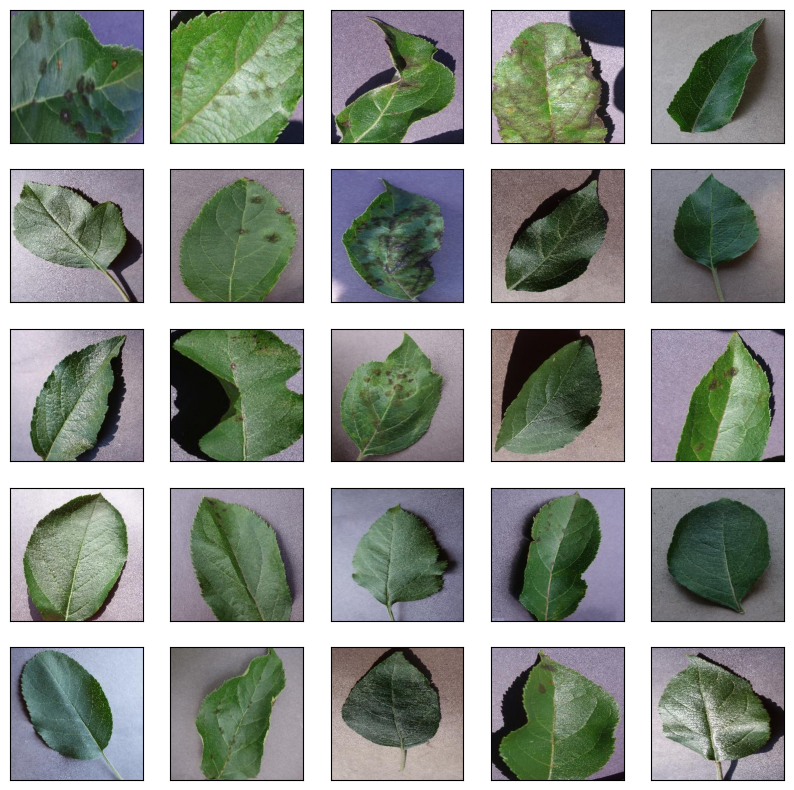

In [5]:
# Se extrae imágenes y etiquetas en formato numpy
x_data = np.array([cv2.resize(img, (256, 256)) for img in ds['images']])
y_data = np.array(ds['labels'][:])

#Se realiza una conversión de la clase 12 (Apple_healthy) en 0 y el resto (Apple_scab) en 1
y_data = np.where(y_data == 12, 0, 1)

#Se genera una permutación aleatoria de índices de x_data
indices = np.random.permutation(len(x_data))

#Se aplica la permutación a los datos
x_data = x_data[indices]
y_data = y_data[indices]

#Se normalizan valores de píxeles
x_data = x_data / 255.0

#Se convierten las etiquetas a one-hot encoding
num_classes = len(np.unique(y_data))
y_data = keras.utils.to_categorical(y_data, num_classes)

#Se divide el dataset en entrenamiento, validación y prueba.
validation_split = 0.1
test_split = 0.1
num_total_samples = len(x_data)
num_train_samples = int(num_total_samples * (1 - validation_split - test_split))
num_val_samples = int(num_total_samples * validation_split)

x_train, x_val, x_test = np.split(x_data, [num_train_samples, num_train_samples + num_val_samples])
y_train, y_val, y_test = np.split(y_data, [num_train_samples, num_train_samples + num_val_samples])

#Se visualizan algunas imágenes del dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

## Creación de modelo Swin Transformer

Se construirá un modelo de visión basado en la arquitectura Swin Transformer, el cual puede procesar imágenes de forma eficiente. Para ello se definen diversos componentes, entre los cuales se encuentran:

- **Ventanas locales**: Dividen la imagen en pequeñas regiones
- **Desplazamiento de ventanas**: Se desplazan las ventanas para que los parches en los bordes de cada ventana puedan interactuar entre sí, mejorando la coherencia global de la imagen.
- **Jerarquía de parches**: En cada etapa, los parches se agrupan y reducen su resolución.

In [6]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

In [7]:
class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [8]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim
        self.num_patch = num_patch
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_mlp = num_mlp

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [9]:
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [10]:
def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x

## Preparación de los conjuntos de datos

Se prepara el dataset con los datos de entrenamiento para que el modelo pueda entrenarse, validarse en cada época y, finalmente, evaluarse.

In [11]:
dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [12]:
dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [13]:
dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Preparación del modelo

Se construye el modelo para la clasificación de imágenes.

In [14]:
input = layers.Input(shape=(256, 768))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

## Entrenamiento del modelo

Se crea y compila el modelo para luego entrenarlo con los datos previamente definidos. Durante el entrenamiento, se evalúa su rendimiento en cada época usando las métricas de `accuracy` y `top-5 accuracy`.

In [15]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

Epoch 1/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - accuracy: 0.5758 - loss: 2.1405 - precision: 0.5758 - recall: 0.5758 - top-5-accuracy: 1.0000 - val_accuracy: 0.8106 - val_loss: 0.5203 - val_precision: 0.8106 - val_recall: 0.8106 - val_top-5-accuracy: 1.0000
Epoch 2/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.8419 - loss: 0.4669 - precision: 0.8419 - recall: 0.8419 - top-5-accuracy: 1.0000 - val_accuracy: 0.9129 - val_loss: 0.3663 - val_precision: 0.9129 - val_recall: 0.9129 - val_top-5-accuracy: 1.0000
Epoch 3/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.8939 - loss: 0.3721 - precision: 0.8939 - recall: 0.8939 - top-5-accuracy: 1.0000 - val_accuracy: 0.8977 - val_loss: 0.3757 - val_precision: 0.8977 - val_recall: 0.8977 - val_top-5-accuracy: 1.0000
Epoch 4/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.9122 - loss: 0.3418 - precision: 0.9122 - recall: 0.9122 - top-5-accuracy: 1.0000 - val_accuracy: 0.9129 - val_loss: 0.3533 - val_precision: 0.912

## Visualización de la pérdida durante el entrenamiento

Se grafica la evolución de la pérdida (*loss*) a lo largo de las épocas para determinar el rendimiento del modelo.

- **Línea de entrenamiento (train_loss)**: muestra cómo mejora el modelo a medida que aprende del conjunto de entrenamiento.
- **Línea de validación (val_loss)**: muestra el rendimiento del modelo con los datos de validaci[on.

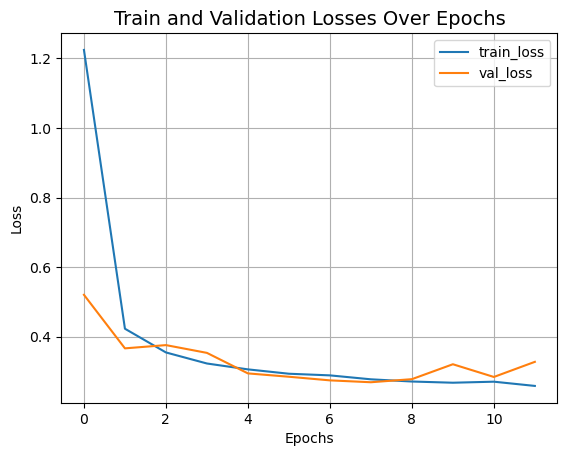

In [16]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Evaluación del modelo en el conjunto de prueba

Se procede con la evaluación del modelo utilizando el conjunto de datos de prueba, es decir, aquellos datos que no fueron usados ni en el entrenamiento ni en la validación, con el objetivo de determinar el rendimiento del modelo. Esta etapa es fundamental para evaluar la capacidad de generalización del modelo y asegurar que no haya sobreajuste a los datos de entrenamiento.

- **loss**: la pérdida del modelo en el conjunto de prueba.
- **accuracy**: indica qué porcentaje de las predicciones fueron correctas.

In [17]:
loss, accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9332 - loss: 0.3153 - precision: 0.9332 - recall: 0.9332 - top-5-accuracy: 1.0000
Test loss: 0.32
Test accuracy: 92.83%
Test top 5 accuracy: 100.0%
Test precision: 92.83%
Test recall: 92.83%


## Evaluación del Modelo con Matriz de Confusión

Se crea la matriz de confusi[on para una mejor evaluaci[on del modelo. Esta compara las predicciones con las etiquetas verdaderas, permitiendo visualizar c[omo es que el modelo clasifica las distintas clases.


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


2025-04-03 13:50:21.358587: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


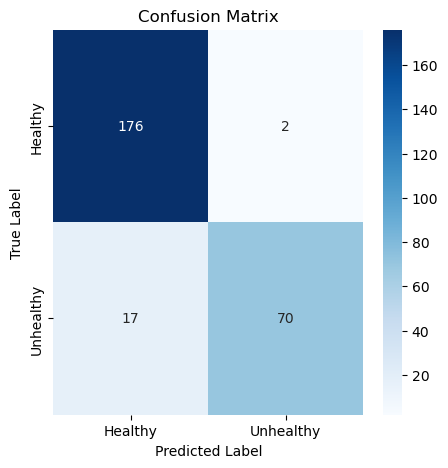

In [18]:
y_pred_probs = model.predict(dataset_test)  

# Convertir a clases (0 o 1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas verdaderas del dataset y convertir el one-hot en clases 0 y 1
y_true = np.concatenate([y for _, y in dataset_test], axis=0)
y_true = np.argmax(y_true, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Etiquetas personalizadas
labels = ["Healthy", "Unhealthy"]

# Visualizar la matriz de confusión
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()